In [1]:
%matplotlib inline
from IPython.display import display
from symderive import (
    Symbol, symbols, Function, Matrix, Rational, Sqrt, R,
    D, Integrate, NIntegrate, Simplify, Expand, Exp, Sin, Cos, Pi, I,
    HermiteH, LaguerreL, AssociatedLaguerreL, AssociatedLegendreP,
    SphericalHarmonicY, Factorial, Gamma,
    Series, Limit, Eq, Solve,
    Eigenvalues, Eigenvectors, Det, Tr,
    FourierTransform, InverseFourierTransform,
    Nest, NestList, FixedPoint, FixedPointList,
    Table, Map, Total,
    Conjugate, Abs,
)
from symderive.ode import DSolve
from symderive.plotting import Plot, ListPlot, ListLinePlot

# Quantum Mechanics with symderive

This notebook demonstrates symbolic quantum mechanics calculations using symderive's
full suite of tools for calculus, linear algebra, differential equations, and plotting.

## Overview

We showcase symderive's capabilities:
1. **DSolve**: Solve the time-dependent Schrödinger equation
2. **Eigenvalues/Eigenvectors**: Matrix quantum mechanics
3. **Series**: Perturbation theory expansions
4. **FourierTransform**: Position ↔ Momentum representation
5. **NestList**: Ladder operator sequences
6. **Plot**: Visualize wavefunctions and probability densities
7. **Integrate**: Normalization and expectation values

## 1. The Quantum Harmonic Oscillator

The Hamiltonian for a 1D quantum harmonic oscillator is:

$$\hat{H} = -\frac{\hbar^2}{2m}\frac{d^2}{dx^2} + \frac{1}{2}m\omega^2 x^2$$

Energy eigenvalues: $E_n = \hbar\omega\left(n + \frac{1}{2}\right)$

Wavefunctions: $\psi_n(x) = \frac{1}{\sqrt{2^n n!}}\left(\frac{m\omega}{\pi\hbar}\right)^{1/4} e^{-\frac{m\omega x^2}{2\hbar}} H_n\left(\sqrt{\frac{m\omega}{\hbar}}x\right)$

In [2]:
# Define symbols for quantum mechanics
x = Symbol('x', real=True)
p = Symbol('p', real=True)  # Momentum
m = Symbol('m', positive=True)
omega = Symbol('omega', positive=True)
hbar = Symbol('hbar', positive=True)
n = Symbol('n', integer=True, nonnegative=True)

In [3]:
# Hermite polynomials - the mathematical core of harmonic oscillator
H0 = HermiteH(0, x)
H1 = HermiteH(1, x)
H2 = HermiteH(2, x)
H3 = HermiteH(3, x)
H4 = HermiteH(4, x)
display(H0, H1, H2, H3, H4)

1

2*x

4*x**2 - 2

8*x**3 - 12*x

16*x**4 - 48*x**2 + 12

In [4]:
def psi_n(n_val, x_var, m_val, omega_val, hbar_val):
    """Construct the n-th harmonic oscillator wavefunction."""
    xi = Sqrt(m_val * omega_val / hbar_val) * x_var
    normalization = 1 / Sqrt(2**n_val * Factorial(n_val)) * (m_val * omega_val / (Pi * hbar_val))**R(1, 4)
    return Simplify(normalization * Exp(-xi**2 / 2) * HermiteH(n_val, xi))

# Ground state (n=0)
psi_0 = psi_n(0, x, m, omega, hbar)
psi_0

m**(1/4)*omega**(1/4)*Exp(-m*omega*x**2/(2*hbar))/(pi**(1/4)*hbar**(1/4))

In [5]:
# First three excited states
psi_1 = psi_n(1, x, m, omega, hbar)
psi_2 = psi_n(2, x, m, omega, hbar)
psi_3 = psi_n(3, x, m, omega, hbar)
display(psi_1, psi_2, psi_3)

sqrt(2)*m**(3/4)*omega**(3/4)*x*Exp(-m*omega*x**2/(2*hbar))/(pi**(1/4)*hbar**(3/4))

sqrt(2)*m**(1/4)*omega**(1/4)*(-hbar/2 + m*omega*x**2)*Exp(-m*omega*x**2/(2*hbar))/(pi**(1/4)*hbar**(5/4))

sqrt(3)*m**(3/4)*omega**(3/4)*x*(-3*hbar + 2*m*omega*x**2)*Exp(-m*omega*x**2/(2*hbar))/(3*pi**(1/4)*hbar**(7/4))

### Plotting Wavefunctions

Let's visualize the wavefunctions using symderive's **Plot** function.
We'll use dimensionless units where $\xi = x\sqrt{m\omega/\hbar}$.

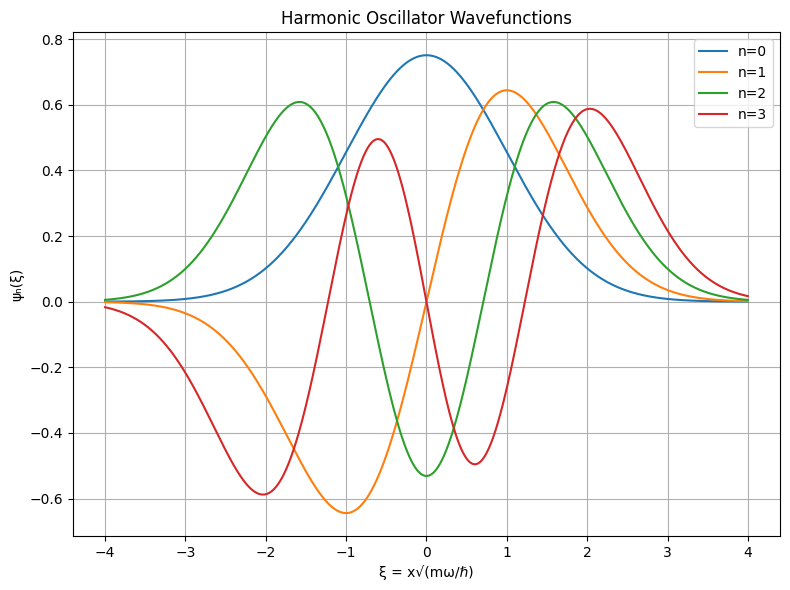

In [6]:
# Dimensionless coordinate for plotting
xi = Symbol('xi', real=True)

# Dimensionless wavefunctions (normalized)
psi0_plot = (1/Pi)**R(1,4) * Exp(-xi**2/2)
psi1_plot = (1/Pi)**R(1,4) * Sqrt(2) * xi * Exp(-xi**2/2)
psi2_plot = (1/Pi)**R(1,4) * (1/Sqrt(2)) * (2*xi**2 - 1) * Exp(-xi**2/2)
psi3_plot = (1/Pi)**R(1,4) * (1/Sqrt(3)) * (2*xi**3 - 3*xi) * Exp(-xi**2/2)

Plot(
    [psi0_plot, psi1_plot, psi2_plot, psi3_plot],
    (xi, -4, 4),
    PlotLabel="Harmonic Oscillator Wavefunctions",
    AxesLabel=["ξ = x√(mω/ℏ)", "ψₙ(ξ)"],
    PlotLegends=["n=0", "n=1", "n=2", "n=3"],
    GridLines=True,
)

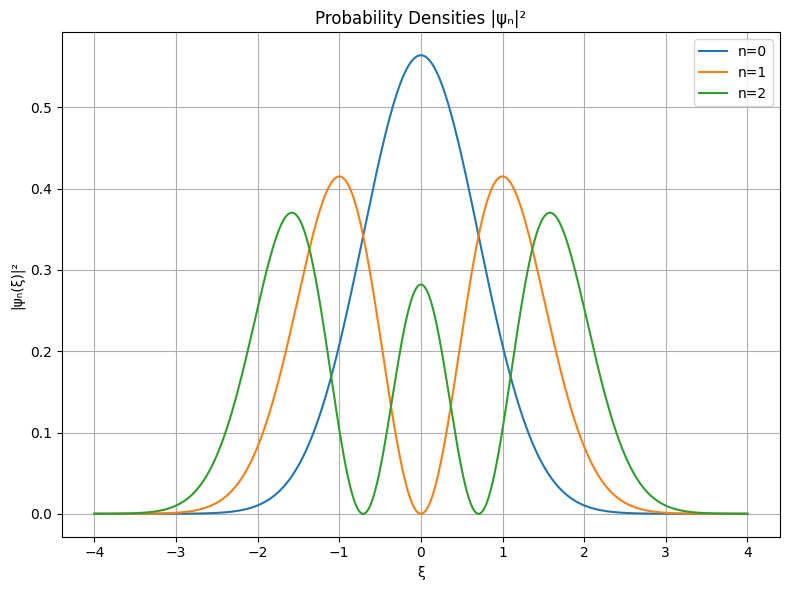

In [7]:
# Probability densities |ψ|²
xi_prob = Symbol('xi', real=True)

prob0 = (1/Pi)**R(1,2) * Exp(-xi_prob**2)
prob1 = (1/Pi)**R(1,2) * 2 * xi_prob**2 * Exp(-xi_prob**2)
prob2 = (1/Pi)**R(1,2) * R(1,2) * (2*xi_prob**2 - 1)**2 * Exp(-xi_prob**2)

Plot(
    [prob0, prob1, prob2],
    (xi_prob, -4, 4),
    PlotLabel="Probability Densities |ψₙ|²",
    AxesLabel=["ξ", "|ψₙ(ξ)|²"],
    PlotLegends=["n=0", "n=1", "n=2"],
    GridLines=True,
)

## 2. Time Evolution via DSolve

The time-dependent Schrödinger equation:

$$i\hbar\frac{\partial\psi}{\partial t} = \hat{H}\psi$$

For an energy eigenstate: $\psi_n(x,t) = \psi_n(x) e^{-iE_n t/\hbar}$

Let's solve the time evolution using **DSolve**.

In [8]:
# Time evolution ODE for coefficient c(t)
t = Symbol('t', real=True)
E = Symbol('E', positive=True)  # Energy eigenvalue
hbar_t = Symbol('hbar', positive=True)

c = Function('c')

# i*hbar * dc/dt = E * c  =>  dc/dt = -i*E*c/hbar
schrodinger_ode = Eq(D(c(t), t), -I * E * c(t) / hbar_t)

# Solve the ODE
time_evolution = DSolve(schrodinger_ode, c(t), t)
time_evolution

Eq(c(t), C1*Exp(-I*E*t/hbar))

The solution $c(t) = C_1 e^{-iEt/\hbar}$ confirms the oscillatory time dependence
of quantum states. The frequency is $\omega = E/\hbar$.

## 3. Matrix Quantum Mechanics

Quantum mechanics can be formulated in matrix form. For a two-level system
(qubit), we use **Eigenvalues** and **Eigenvectors**.

In [9]:
# Two-level system (spin-1/2 in magnetic field)
Delta = Symbol('Delta', real=True)  # Energy splitting
V = Symbol('V', real=True)  # Coupling

# Hamiltonian matrix
H_2level = Matrix([
    [Delta/2, V],
    [V, -Delta/2]
])

# Find eigenvalues (energy levels)
energies = Eigenvalues(H_2level)
energies

{-sqrt(Delta**2 + 4*V**2)/2: 1, sqrt(Delta**2 + 4*V**2)/2: 1}

In [10]:
# Find eigenvectors (stationary states)
states = Eigenvectors(H_2level)
states

[(-sqrt(Delta**2 + 4*V**2)/2,
  1,
  [Matrix([
   [Delta/(2*V) - sqrt(Delta**2 + 4*V**2)/(2*V)],
   [                                          1]])]),
 (sqrt(Delta**2 + 4*V**2)/2,
  1,
  [Matrix([
   [Delta/(2*V) + sqrt(Delta**2 + 4*V**2)/(2*V)],
   [                                          1]])])]

The eigenvalues are $E_\pm = \pm\sqrt{(\Delta/2)^2 + V^2}$, showing the
**avoided crossing** phenomenon in quantum systems.

### Pauli Matrices and Spin

The Pauli matrices form a basis for 2×2 Hermitian matrices.

In [11]:
# Pauli matrices
sigma_x = Matrix([[0, 1], [1, 0]])
sigma_y = Matrix([[0, -I], [I, 0]])
sigma_z = Matrix([[1, 0], [0, -1]])
identity = Matrix([[1, 0], [0, 1]])

# Properties: Tr(sigma_i) = 0, eigenvalues = ±1
display(Tr(sigma_x), Tr(sigma_y), Tr(sigma_z))

0

0

0

In [12]:
# Eigenvalues of Pauli matrices (should all be {-1: 1, 1: 1})
display(Eigenvalues(sigma_x), Eigenvalues(sigma_y), Eigenvalues(sigma_z))

{-1: 1, 1: 1}

{-1: 1, 1: 1}

{1: 1, -1: 1}

## 4. Perturbation Theory via Series

First-order perturbation theory: For $\hat{H} = \hat{H}_0 + \lambda \hat{H}'$,

$$E_n = E_n^{(0)} + \lambda \langle n | \hat{H}' | n \rangle + O(\lambda^2)$$

Let's use **Series** to expand energies in the perturbation parameter.

In [13]:
# Perturbed two-level system
E0 = Symbol('E_0', positive=True)  # Unperturbed energy
lam = Symbol('lambda', real=True)  # Perturbation strength

# Exact energy with perturbation: E = sqrt(E0^2 + lambda^2)
E_exact = Sqrt(E0**2 + lam**2)

# Series expansion in lambda (perturbation theory)
E_perturbation = Series(E_exact, (lam, 0, 4))
E_perturbation

-lambda**4/(8*E_0**3) + lambda**2/(2*E_0) + E_0 + O(lambda**5)

The series expansion shows:
- Zeroth order: $E_0$ (unperturbed)
- Second order: $\lambda^2/(2E_0)$ (quadratic correction)
- Fourth order: $-\lambda^4/(8E_0^3)$ (higher correction)

First order vanishes for this symmetric perturbation.

## 5. Momentum Space via Fourier Transform

The momentum-space wavefunction is the Fourier transform:

$$\tilde{\psi}(p) = \frac{1}{\sqrt{2\pi\hbar}} \int_{-\infty}^{\infty} \psi(x) e^{-ipx/\hbar} dx$$

In [14]:
# Position-space Gaussian wavefunction (ground state of HO)
x_ft = Symbol('x', real=True)
p_ft = Symbol('p', real=True)
sigma_pos = Symbol('sigma', positive=True)  # Position width

# Gaussian in position space (normalized)
psi_x = (1/(Pi * sigma_pos**2))**R(1,4) * Exp(-x_ft**2 / (2*sigma_pos**2))

# Fourier transform to momentum space
psi_p = FourierTransform(psi_x, x_ft, p_ft)
psi_p_simplified = Simplify(psi_p)

{"position_space": psi_x, "momentum_space": psi_p_simplified}

{'position_space': Exp(-x**2/(2*sigma**2))/(pi**(1/4)*sqrt(sigma)),
 'momentum_space': sqrt(2)*pi**(1/4)*sqrt(sigma)*Exp(-2*pi**2*p**2*sigma**2)}

The Fourier transform of a Gaussian is another Gaussian!
Width in momentum space: $\sigma_p \propto 1/\sigma_x$ - this demonstrates
the uncertainty principle: $\Delta x \cdot \Delta p \geq \hbar/2$.

## 6. Ladder Operators via NestList

Creation ($\hat{a}^\dagger$) and annihilation ($\hat{a}$) operators:

$$\hat{a}|n\rangle = \sqrt{n}|n-1\rangle, \quad \hat{a}^\dagger|n\rangle = \sqrt{n+1}|n+1\rangle$$

We can use **NestList** to generate sequences of states.

In [15]:
# Track quantum number under repeated creation operator
def apply_creation(n_val):
    """a^dagger raises n -> n+1, with coefficient sqrt(n+1)"""
    return (n_val + 1, Sqrt(n_val + 1))

# Start from ground state n=0, apply a^dagger 5 times
# Track (n, cumulative_coefficient)
def creation_sequence(state):
    n_val, coeff = state
    new_n = n_val + 1
    new_coeff = coeff * Sqrt(new_n)
    return (new_n, new_coeff)

# Generate sequence: |0⟩ -> |1⟩ -> |2⟩ -> |3⟩ -> |4⟩ -> |5⟩
ladder_sequence = NestList(creation_sequence, (0, 1), 5)
ladder_sequence

[(0, 1), (1, 1), (2, sqrt(2)), (3, sqrt(6)), (4, 2*sqrt(6)), (5, 2*sqrt(30))]

The sequence shows: $(a^\dagger)^n |0\rangle = \sqrt{n!} |n\rangle$

## 7. Hydrogen Atom Radial Functions

The hydrogen atom has radial wavefunctions involving associated Laguerre polynomials.

In [16]:
# Hydrogen atom symbols
r = Symbol('r', positive=True)
theta = Symbol('theta', real=True)
phi = Symbol('phi', real=True)
a0 = Symbol('a_0', positive=True)  # Bohr radius
Z = Symbol('Z', positive=True, integer=True)  # Atomic number

In [17]:
def R_nl(n_val, l_val, r_var, Z_val, a0_val):
    """Radial wavefunction for hydrogen-like atom."""
    rho = 2 * Z_val * r_var / (n_val * a0_val)
    norm = Sqrt(
        (2 * Z_val / (n_val * a0_val))**3 *
        Factorial(n_val - l_val - 1) /
        (2 * n_val * Factorial(n_val + l_val)**3)
    )
    return Simplify(norm * Exp(-rho / 2) * rho**l_val *
                   AssociatedLaguerreL(n_val - l_val - 1, 2*l_val + 1, rho))

# 1s orbital (n=1, l=0)
R_10 = R_nl(1, 0, r, Z, a0)
R_10

2*Z**(3/2)*Exp(-Z*r/a_0)/a_0**(3/2)

In [18]:
# 2s and 2p orbitals
R_20 = Simplify(R_nl(2, 0, r, Z, a0))
R_21 = Simplify(R_nl(2, 1, r, Z, a0))
display(R_20, R_21)

sqrt(2)*Z**(3/2)*(-Z*r + 2*a_0)*Exp(-Z*r/(2*a_0))/(8*a_0**(5/2))

sqrt(6)*Z**(5/2)*r*Exp(-Z*r/(2*a_0))/(72*a_0**(5/2))

In [19]:
# Spherical harmonics for angular part
Y_00 = SphericalHarmonicY(0, 0, theta, phi)  # s orbital
Y_10 = SphericalHarmonicY(1, 0, theta, phi)  # p_z orbital
Y_11 = SphericalHarmonicY(1, 1, theta, phi)  # p_x + i*p_y
display(Y_00, Y_10, Y_11)

SphericalHarmonicY(0, 0, theta, phi)

SphericalHarmonicY(1, 0, theta, phi)

SphericalHarmonicY(1, 1, theta, phi)

## 8. Variational Method via FixedPoint

The variational principle: For any trial wavefunction $\psi_\text{trial}$,

$$E[\psi] = \frac{\langle\psi|\hat{H}|\psi\rangle}{\langle\psi|\psi\rangle} \geq E_0$$

We can use **FixedPoint** to optimize variational parameters.

In [20]:
# Simple variational optimization: Newton's method for energy minimum
# E(alpha) = alpha^2/2 + 1/(2*alpha^2) for Gaussian trial function
# Minimum at alpha = 1

def variational_step(alpha):
    """One step of gradient descent for E(alpha) = alpha^2/2 + 1/(2*alpha^2)"""
    # dE/dalpha = alpha - 1/alpha^3
    # Newton: alpha_new = alpha - dE/dalpha / d2E/dalpha2
    # d2E/dalpha2 = 1 + 3/alpha^4
    gradient = alpha - 1/alpha**3
    hessian = 1 + 3/alpha**4
    return alpha - gradient/hessian

# Start from alpha=2, converge to optimal alpha=1
alpha_sequence = FixedPointList(variational_step, 2.0, max_iter=10, tol=1e-10)
alpha_sequence

[2.0,
 0.42105263157894735,
 0.5555828369939679,
 0.7179745826457432,
 0.8794054158414036,
 0.9776395597187084,
 0.9992448050455036,
 0.999999144306008,
 0.9999999999989017,
 1.0]

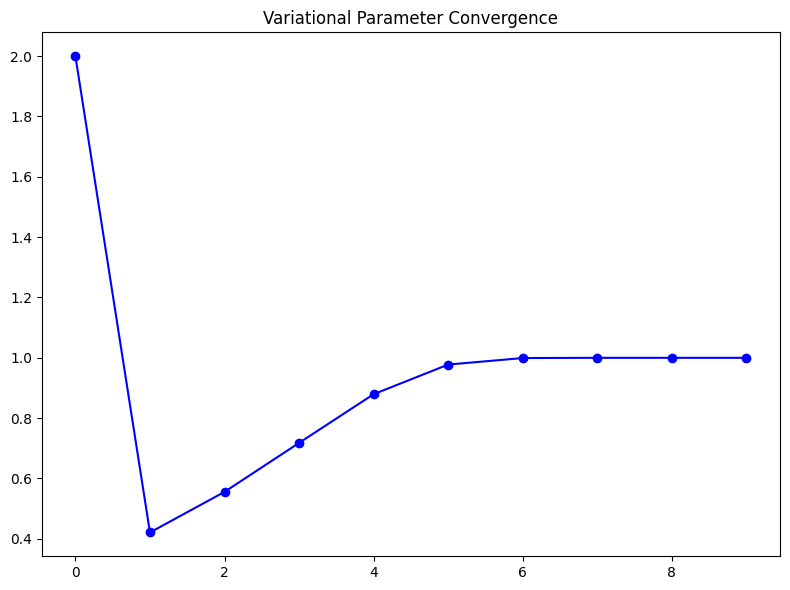

In [21]:
# Plot convergence
alpha_data = [(i, a) for i, a in enumerate(alpha_sequence)]

ListLinePlot(
    alpha_data,
    PlotLabel="Variational Parameter Convergence",
    AxesLabel=["Iteration", "α"],
    PlotStyle="Blue",
    GridLines=True,
)

## Summary

We demonstrated symderive's quantum mechanics capabilities:

| Feature | Usage |
|---------|-------|
| **DSolve** | Time-dependent Schrödinger equation |
| **Eigenvalues/Eigenvectors** | Matrix quantum mechanics, spin systems |
| **Series** | Perturbation theory expansions |
| **FourierTransform** | Position ↔ Momentum representation |
| **NestList** | Ladder operator sequences |
| **FixedPoint** | Variational optimization |
| **Plot** | Wavefunction and probability visualization |
| **Integrate** | Normalization and expectation values |
| **HermiteH, LaguerreL, SphericalHarmonicY** | Special functions |

symderive provides comprehensive tools for symbolic quantum mechanics!